# The KNN Model built to analyse the CBIS-DDSM datset

## Data preprocessing

### Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


### Reading the dataset

>The mass_case_description_train_set from the CBIS-DDSM dataset is used to train the KNN model. This subset has the structured descriptors for each breast mas, like breast density, mass shape, margins and the assessment values. It also includes the target variable which are the pathology labels such as bengign (non-cancerous) and malignant (canceerous).

>Using this data allows the KNN to learn from radiological characteristics rather than raw images like CNN would. This serves a similar purpose as the CNN, both aim to predict malignancy but with different inputs. This format, using structured mass descriptors for KNN and images for CNN, enables a comparative analysis of how different data types and learning approaches can end up with the same daignosis.

In [ ]:
df = pd.read_csv("/content/mass_case_description_train_set.csv")

### Previewing the dataset

In [ ]:
df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


Standardising feature names to exclude white spaces

In [ ]:
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left_or_right_breast     1318 non-null   object
 3   image_view               1318 non-null   object
 4   abnormality_id           1318 non-null   int64 
 5   abnormality_type         1318 non-null   object
 6   mass_shape               1314 non-null   object
 7   mass_margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image_file_path          1318 non-null   object
 12  cropped_image_file_path  1318 non-null   object
 13  ROI_mask_file_path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [ ]:
print("\nDataset shape: ", df.shape)


Dataset shape:  (1318, 14)


>14 features and 1318 records (14 columns, 1318 rows)

In [ ]:
num_patients = df['patient_id'].nunique()
print(f"Number of unique patients: {num_patients}")

Number of unique patients: 691


Checking for null values

In [ ]:
print(df.isnull().sum())

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64


> There are 43 null values in mass margins and 4 in mass shape. This will be addressed so as not to skew or train the model incorrectly.

Some Issues:
* Misssing values will distort the similarity calculations
* Dropping the rows will reduce the sample diversity, especially since this csv only has 1318 records and if we drop them the associating images will be removed from the CNN analysis.
* Dropping the column entirely, is not an option since mass margins is highly important into understanding what these potential tumours look like. This feature is used to describe the shape and and characteristics of the edges of the detected mass from the mammograms.

Optimal fix:
Replacing those areas with the mode

Code to view the missing values and the specific rows

In [ ]:
from IPython.display import display
missing_vals = df[df[['mass_margins', 'mass_shape']].isnull().any(axis=1)]
display(missing_vals)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
56,P_00079,2,RIGHT,CC,1,mass,ARCHITECTURAL_DISTORTION,NaN,0,MALIGNANT,4,Mass-Training_P_00079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_00079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_00079_RIGHT_CC_1/1.3.6.1.4.1.9...
57,P_00079,2,RIGHT,MLO,1,mass,ARCHITECTURAL_DISTORTION,NaN,0,MALIGNANT,4,Mass-Training_P_00079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00079_RIGHT_MLO_1/1.3.6.1.4.1....
158,P_00226,4,LEFT,CC,1,mass,FOCAL_ASYMMETRIC_DENSITY,NaN,3,MALIGNANT,1,Mass-Training_P_00226_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00226_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00226_LEFT_CC_1/1.3.6.1.4.1.95...
159,P_00226,4,LEFT,MLO,1,mass,FOCAL_ASYMMETRIC_DENSITY,NaN,3,MALIGNANT,1,Mass-Training_P_00226_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00226_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00226_LEFT_MLO_1/1.3.6.1.4.1.9...
161,P_00229,2,LEFT,MLO,1,mass,ASYMMETRIC_BREAST_TISSUE,NaN,3,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00229_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00229_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00229_LEFT_MLO_1/1.3.6.1.4.1.9...
251,P_00376,1,RIGHT,CC,1,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00376_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_00376_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_00376_RIGHT_CC_1/1.3.6.1.4.1.9...
252,P_00376,1,RIGHT,MLO,1,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00376_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00376_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00376_RIGHT_MLO_1/1.3.6.1.4.1....
253,P_00376,1,RIGHT,MLO,2,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00376_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00376_RIGHT_MLO_2/1.3.6.1.4.1....,Mass-Training_P_00376_RIGHT_MLO_2/1.3.6.1.4.1....
254,P_00376,1,RIGHT,MLO,3,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00376_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00376_RIGHT_MLO_3/1.3.6.1.4.1....,Mass-Training_P_00376_RIGHT_MLO_3/1.3.6.1.4.1....
255,P_00376,1,RIGHT,MLO,4,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,Mass-Training_P_00376_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00376_RIGHT_MLO_4/1.3.6.1.4.1....,Mass-Training_P_00376_RIGHT_MLO_4/1.3.6.1.4.1....


Since these records are linked to specific patients, this code is to view which patients are affected by missing information.
If one patient has the same missing information across all records linked to them, then that patient can be potentially dropped.

> Will need to include this exclusion of patients or rows if needed in the CNN version to maintain consistency for the patients both model's are trained on. This is to ensure the correct and true comparison across both models.

In [ ]:
print("Affected patient IDs:", missing_vals['patient_id'].unique())

Affected patient IDs: ['P_00079' 'P_00226' 'P_00229' 'P_00376' 'P_00385' 'P_00419' 'P_00439'
 'P_00517' 'P_00710' 'P_00775' 'P_00778' 'P_00847' 'P_00902' 'P_01133'
 'P_01142' 'P_01185' 'P_01207' 'P_01231' 'P_01324' 'P_01386' 'P_01398'
 'P_01498' 'P_01635' 'P_01717' 'P_01814' 'P_01849']


In [ ]:
missing_counts = missing_vals.groupby('patient_id').size().reset_index(name='missing_record_count')

missing_counts = missing_counts.sort_values(by='missing_record_count', ascending=False)

print(missing_counts.to_string(index=False))

patient_id  missing_record_count
   P_00376                     5
   P_00778                     4
   P_00226                     2
   P_00385                     2
   P_00419                     2
   P_00517                     2
   P_00775                     2
   P_00710                     2
   P_01185                     2
   P_00079                     2
   P_01635                     2
   P_01849                     2
   P_01398                     2
   P_01324                     2
   P_00439                     1
   P_00229                     1
   P_00902                     1
   P_00847                     1
   P_01231                     1
   P_01207                     1
   P_01142                     1
   P_01133                     1
   P_01498                     1
   P_01386                     1
   P_01717                     1
   P_01814                     1


The above gives a view of how many paatients have null data nad how many rrecords with null values are linked to each patient.

The null values are replaced using the most frequent value or mode foudn from each patient's associated records. If a patient has multiple entries, the known values from them will be used to fill in missing data in the other records linked to that patient.  

If the patient only has null values for that feature across all records linked to them, then it becomes unknown. That will be encoded later in the analysis.

In [ ]:
df['mass_margins'] = df.groupby('patient_id')['mass_margins'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'UNKNOWN'))#McKinney, 2010

df['mass_shape'] = df.groupby('patient_id')['mass_shape'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'UNKNOWN')) #McKinney, 2010

### Dropping the columns
Dropping features that are not particularly usefull for the KNN model. This will also decrease the performance strain.

* patient_id
* image file path
* cropped image file path
* ROI mask file path

In [ ]:
#creating array of feature names to drop
drop_cols = ['patient_id','image file path','cropped image file path','ROI mask file path']
df = df.drop(columns=drop_cols, errors='ignore')
df.columns = df.columns.str.strip() #taking out white spaces from column names like "mass shape"

### Encoding the categorical variables

retrieving all categorical columns

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns: ", list(categorical_cols))

Categorical columns:  ['left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins', 'pathology', 'image_file_path', 'cropped_image_file_path', 'ROI_mask_file_path']


encoding

In [ ]:
df["label"] = df["pathology"].replace({
    "MALIGNANT": 1,
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 0
}) #McKinney, 2010

/tmp/ipython-input-3379733718.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["pathology"].replace({


In [ ]:
lblEncoded_dict = {}
for col in categorical_cols:
  lblEncoded = LabelEncoder()
  df[col] = lblEncoded.fit_transform(df[col].astype(str))
  lblEncoded_dict = lblEncoded

  #Pedregosa et al., 2011

Final view of the dataset, post clean

In [ ]:
print("\nCleaned dataset shape:", df.shape)
display(df.head())


Cleaned dataset shape: (1318, 14)


,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,label
0,3,0,0,1,0,4,14,4,2,4,0,0,0,1
1,3,0,1,1,0,4,14,4,2,4,1,1,1,1
2,3,0,0,1,0,0,4,4,0,3,2,2,2,0
3,3,0,1,1,0,0,4,4,0,3,3,3,3,0
4,3,1,1,1,0,12,0,4,0,5,4,4,4,0


## Visualisations (EDA)

* O --> Benign
* 2 --> malignant
* 1 --> Benign_without_callback

Visualising the distribution of pathology results in a count plot.

/tmp/ipython-input-4277984220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pathology', palette='plasma')


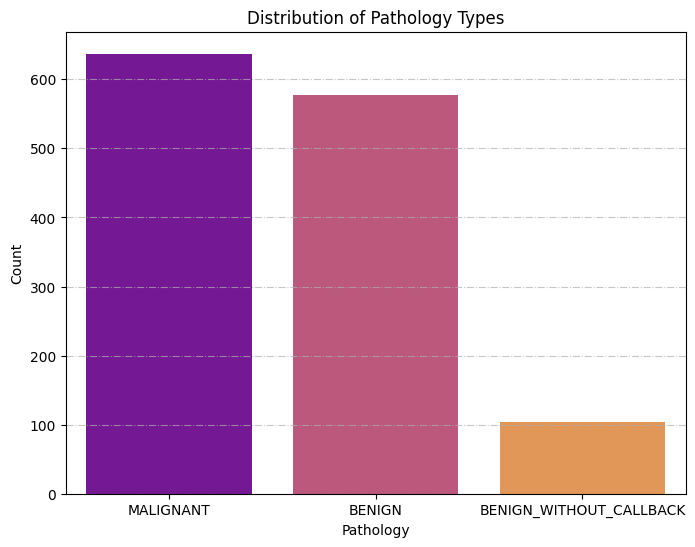

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='pathology', palette='plasma')
plt.title('Distribution of Pathology Types')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-.', alpha=0.7)
plt.show()

#Waskom, 2021

Comparing asssessment scores between benign and maignant cases to see if there is a separaton. Also uncovering any outliers.

/tmp/ipython-input-1618055724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='plasma')


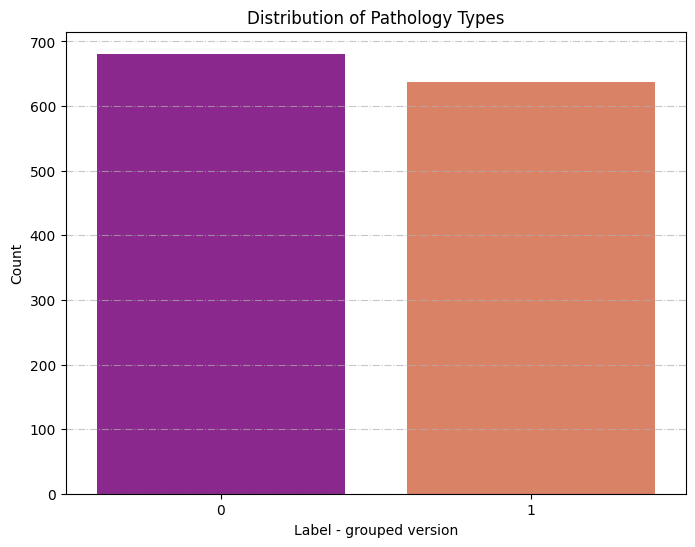

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='label', palette='plasma')
plt.title('Distribution of Pathology Types')
plt.xlabel('Label - grouped version')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-.', alpha=0.7)
plt.show()

#Waskom, 2021

> The version above invludes the grouped values for benign (0) and malignant at 1. We can see a more balanced distribution for the values.

/tmp/ipython-input-3077504068.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='pathology', y='assessment', palette='inferno')


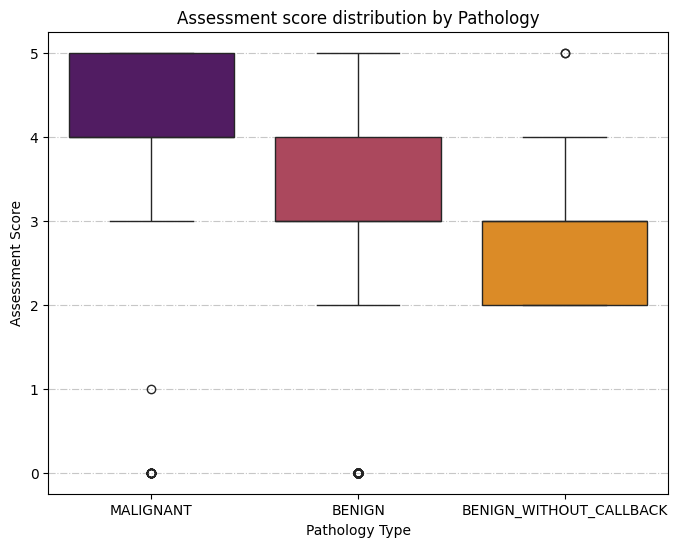

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='pathology', y='assessment', palette='inferno')
plt.title('Assessment score distribution by Pathology')
plt.xlabel('Pathology Type')
plt.ylabel('Assessment Score')
plt.grid(axis='y', linestyle='-.', alpha=0.7)
plt.show()

#Waskom, 2021

This box plot shows the distribution of median values in each pathology category. The malignant cases have a higher assessment scores. It is unclear what assessment means, as it was not explicitly stated in the TCIA site. Assuming it refers to tumour size, it would be viable to assume that larger tumour sizes would correlate with malignancy.

## Training

### Splitting the dataset

In [ ]:
X = df.drop(columns=['label'])
y = df['label']

#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

Scaling the features

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Grid Search Optimisation

> Gird search is added in to select the optimal number of neighbours (k) and test the distance metrics. Grid searching is an optimisation technique for hyperparameter tuning (Neurosnap, 2023)

imports

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

Setting different parameters in array

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train )

#Pedregosa et al.,2011

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Getting the best scores from grid search results

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", round(grid_search.best_score_, 4))

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation accuracy:  0.9772


Getting the best knn and retraining the model oon the full train data

In [ ]:
best_knn = grid_search.best_estimator_

best_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11)

Evaluating on the test data

In [ ]:
y_pred = best_knn.predict(X_test)

Adding auroc

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_proba = best_knn.predict_proba(X_test)[:, 1]

Outputting accuracy scores

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(accuracy, 4))

Test Accuracy: 0.9811


>yielded a 75.76% accuracy score which is okay, not great. Which was a previous run without grouping the two benign labels.
> Now we yield a 98.11% accuracy with grouped benign labels. However the issue of the the mass margins having 43 null is still not handled.

## Results display

Report on the classifcation results (like recall, precision etc.)

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       136
           1       0.98      0.98      0.98       128

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



> A strong model performance at 98% accuracy, precision, recall and f1-Score

> Will explain in findings report what this means for total model ability.

Confusion Matrix

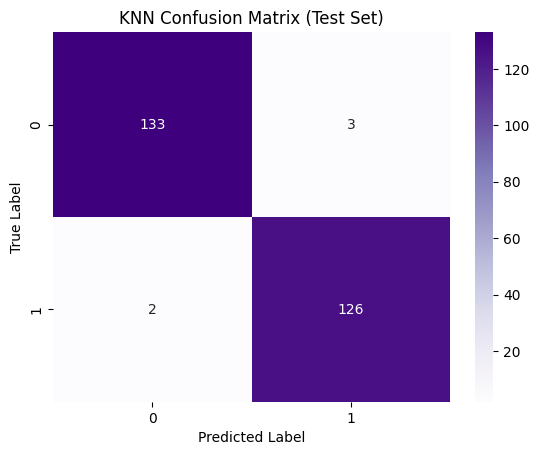

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('KNN Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Pedregosa et al.,2011

> From the confusion matrix we can see
> * 133 true negatives, meaning 133 were correctly classified as benign.
> * 126 true positives, meaning 126 were correctly classified as malignant.
> * 3 were incorrectly classified as malignant
> * 2 were incorrectly classified as benign.


AUROC Evaluation

In [ ]:
auroc = roc_auc_score(y_test, y_proba)
print("AUROC Score:", round(auroc, 4))

#Pedregosa et al.,2011

AUROC Score: 0.9991


An Accuracy Under the Curve Score of 0.9991 means the model is nearly perfect at distinguishing between the two classes. It can almmost always rank a true positive higher than a false positive. AUROC measures a model's ability to distinguish between classes across all classification thresholds, with higher values showing a better performance. This score reflects that the model performs well across all classsification thresholds. This is validated by the accuracy, precision, recall and F1-Scores being at 0.98.

# References
Neurosnap. 2023. Understanding Grid Search as an Optimization Algorithm in Machine Learning. 13 April 2023. [Online]. Available at: https://neurosnap.ai/blog/post/643748be49872f3862f39aed. [Accessed on 2 October 2025].

Pedregosa, F. et al. 2011. Scikit-learn: Machine Learning in Python. Available at: https://scikit-learn.org/stable/ [17 November 2025]

McKinney, W. 2010. Data Structures for Statistical Computing in Python, Preceedings of the 9th Python in Science Conference, pp. 51-56. doi:
https://doi.org/10.25080/Majora-92bf1922-00a [Accessed on 17 November 2025].

Waskom, M. 2021. seaborn, Seaborn Statistical Data Visualization. Available at: https://seaborn.pydata.org/ [Accessed on 17 November 2025].